In [49]:
import tensorflow as tf
from tensorflow import keras

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [70]:
#downloading dataset
import pathlib
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
data_dir = tf.keras.utils.get_file('jpg', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

344862509/344862509 [==============================] - 74s 0us/step


In [75]:
#number of images in dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images: ", image_count)

Number of images:  0


In [72]:
#defining parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [1]:
#validation split when developing model
#use 80% of the images for training and 20% for validation

train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

NameError: name 'tf' is not defined

In [8]:
#validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
#class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


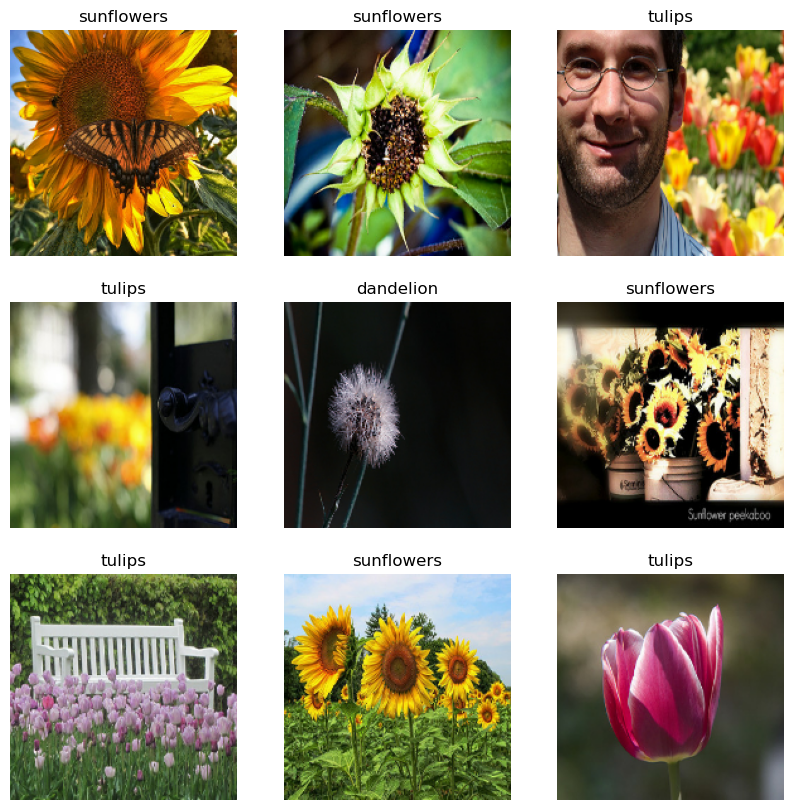

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#neural network values should be small [0,255] range is too large.
#you can standardize the values bu using the tf.keras.layers.Rescaling

normalization_layer = layers.Rescaling(1./255)

In [17]:
#applying to dataset using Dataset.map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
#creating the model
#keras sequential model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
#veiwing training and validation accuracy for each training epoch
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [23]:
#view all layers of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [25]:
#train the model
epochs=10
history=model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs)

Epoch 1/10
92/92 [==============================] - 17s 182ms/step - loss: 1.3453 - accuracy: 0.4257 - val_loss: 1.0617 - val_accuracy: 0.5708
Epoch 2/10
92/92 [==============================] - 18s 190ms/step - loss: 0.9777 - accuracy: 0.6209 - val_loss: 1.0048 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 19s 212ms/step - loss: 0.7868 - accuracy: 0.6904 - val_loss: 0.9098 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 18s 194ms/step - loss: 0.5749 - accuracy: 0.7967 - val_loss: 0.9087 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 17s 185ms/step - loss: 0.3769 - accuracy: 0.8658 - val_loss: 0.9398 - val_accuracy: 0.6853
Epoch 6/10
92/92 [==============================] - 18s 194ms/step - loss: 0.2042 - accuracy: 0.9319 - val_loss: 1.3782 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 18s 191ms/step - loss: 0.1192 - accuracy: 0.9680 - val_loss: 1.2376 - val_accuracy: 0.6621

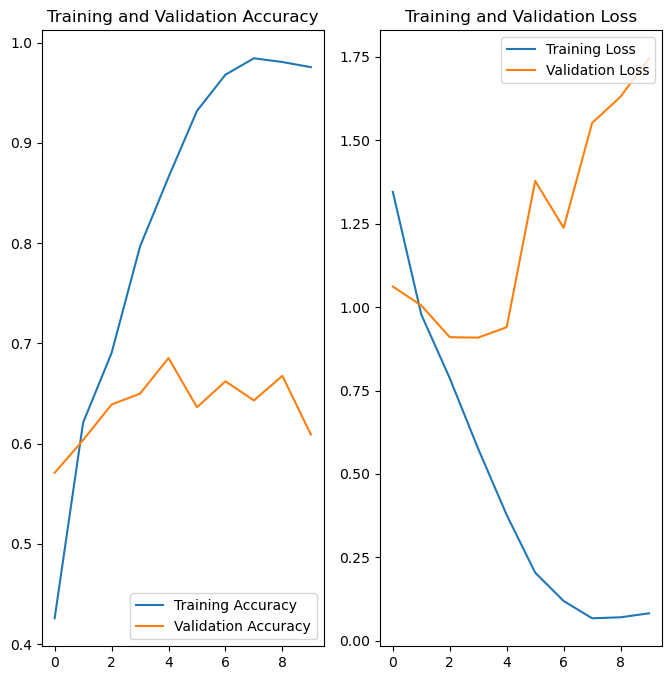

In [27]:
#visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#here the training accuracy and validation accuracy are off by large margins
# and the model has achieved only around a 60% accuracy on the validation set


In [30]:
#overfitting
#multiple ways to fight overfitting
#data augmentation is one of them
#overfitting genrally occus when there are a small number of training examples
#data augmentation takes the approach of 
#generating additional training data form existing examples
#by augmenting them by useing random transformations that yield 
#believable looking images

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

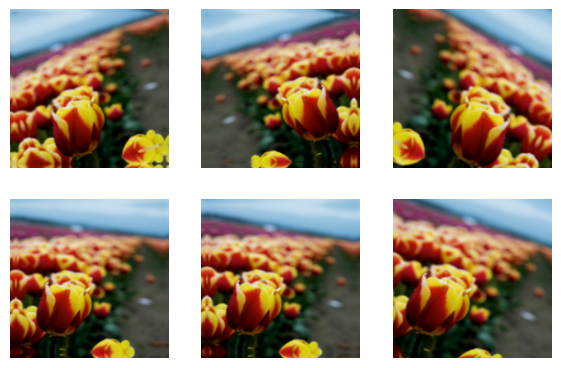

In [32]:
#visualizing data augmentation on random images
plt.figure(figsize=(7,7))
for images, _ in train_ds.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [33]:
#another way to reduce overfitting is to introduce dropout to the
#network
#when you apply dropout to a layer it randomly drops out a number
# of output units from the layer during the training process.

#introducing dropout regularization to the network
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [34]:
#compile and train the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [36]:
epochs = 15
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs)

Epoch 1/15
92/92 [==============================] - 19s 205ms/step - loss: 1.2979 - accuracy: 0.4510 - val_loss: 1.0732 - val_accuracy: 0.5899
Epoch 2/15
92/92 [==============================] - 19s 204ms/step - loss: 1.0391 - accuracy: 0.5899 - val_loss: 1.0504 - val_accuracy: 0.6104
Epoch 3/15
92/92 [==============================] - 19s 203ms/step - loss: 0.9379 - accuracy: 0.6352 - val_loss: 0.9676 - val_accuracy: 0.6376
Epoch 4/15
92/92 [==============================] - 19s 203ms/step - loss: 0.8598 - accuracy: 0.6696 - val_loss: 0.8938 - val_accuracy: 0.6689
Epoch 5/15
92/92 [==============================] - 20s 214ms/step - loss: 0.7930 - accuracy: 0.7033 - val_loss: 0.7834 - val_accuracy: 0.6935
Epoch 6/15
92/92 [==============================] - 20s 217ms/step - loss: 0.7718 - accuracy: 0.7088 - val_loss: 0.8853 - val_accuracy: 0.6608
Epoch 7/15
92/92 [==============================] - 22s 235ms/step - loss: 0.7373 - accuracy: 0.7241 - val_loss: 0.7480 - val_accuracy: 0.7234

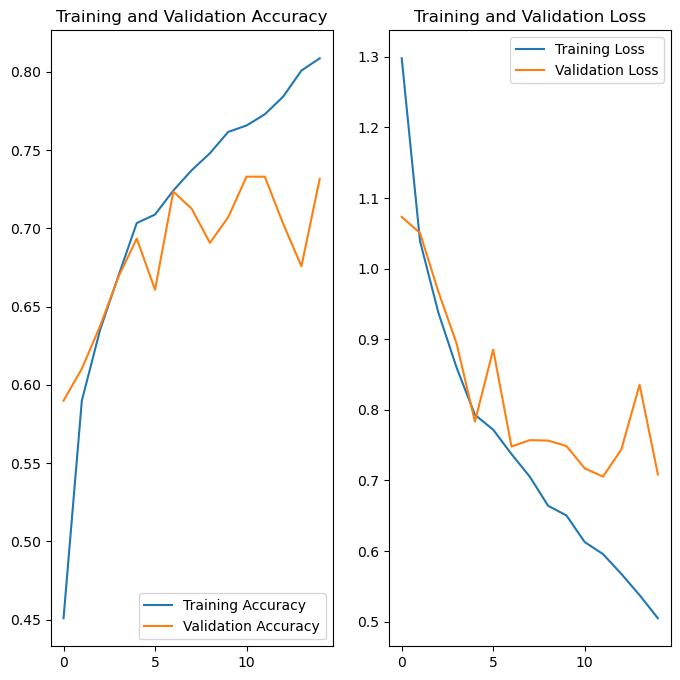

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
img = tf.keras.utils.load_img(
"flowers/tulip1.jpeg", target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #create batch


In [46]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 85ms/step
This image most likely belongs to tulips with a 97.96 percent confidence.
